In [1]:
from collections import Counter

import numpy as np
import pandas as pd
from pylab import mpl, plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (10, 6)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.combine import SMOTEENN
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import ClusterCentroids

import warnings
warnings.filterwarnings('ignore')

---

imbalanced-learn [Home](https://imbalanced-learn.org/stable/)<br>
scikit-learn [Home](https://scikit-learn.org/stable/)<br>

---

### Data Import

In [2]:
df_lending = pd.read_csv('lending_data.csv')
df_lending.head()

,loan_size,interest_rate,homeowner,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,loan_status
0,10700.0,7.672,own,52800,0.431818,5,1,22800,low_risk
1,8400.0,6.692,own,43600,0.311927,3,0,13600,low_risk
2,9000.0,6.963,rent,46100,0.349241,3,0,16100,low_risk
3,10700.0,7.664,own,52700,0.430740,5,1,22700,low_risk
4,10800.0,7.698,mortgage,53000,0.433962,5,1,23000,low_risk


In [3]:
df_lending.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77536 entries, 0 to 77535
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   loan_size         77536 non-null  float64
 1   interest_rate     77536 non-null  float64
 2   homeowner         77536 non-null  object 
 3   borrower_income   77536 non-null  int64  
 4   debt_to_income    77536 non-null  float64
 5   num_of_accounts   77536 non-null  int64  
 6   derogatory_marks  77536 non-null  int64  
 7   total_debt        77536 non-null  int64  
 8   loan_status       77536 non-null  object 
dtypes: float64(3), int64(4), object(2)
memory usage: 5.3+ MB


In [4]:
df_lending.describe().style.background_gradient()

,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt
count,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000
mean,9805.562577,7.292333,49221.949804,0.377318,3.826610,0.392308,19221.949804
std,2093.223153,0.889495,8371.635077,0.081519,1.904426,0.582086,8371.635077
min,5000.000000,5.250000,30000.000000,0.000000,0.000000,0.000000,0.000000
25%,8700.000000,6.825000,44800.000000,0.330357,3.000000,0.000000,14800.000000
50%,9500.000000,7.172000,48100.000000,0.376299,4.000000,0.000000,18100.000000
75%,10400.000000,7.528000,51400.000000,0.416342,4.000000,1.000000,21400.000000
max,23800.000000,13.235000,105200.000000,0.714829,16.000000,3.000000,75200.000000


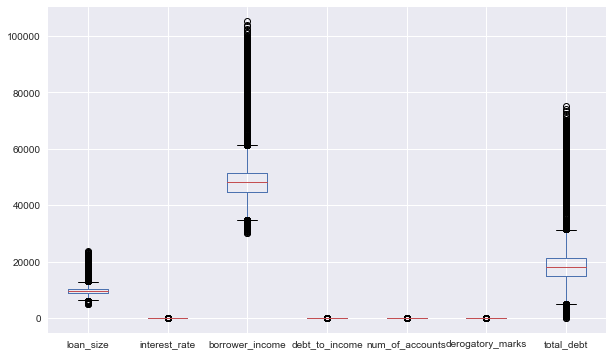

In [5]:
df_lending.boxplot();

In [6]:
X = df_lending.drop(columns='loan_status')
X = pd.get_dummies(X)

target = ['loan_status']
y = df_lending.loc[:, target].copy()
display(y['loan_status'].value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

low_risk     75036
high_risk     2500
Name: loan_status, dtype: int64

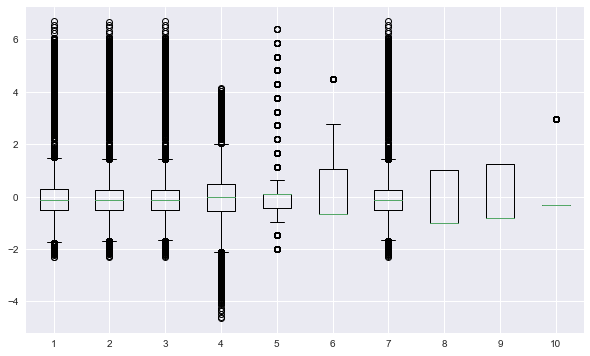

In [7]:
plt.boxplot(X_train_scaled);

---

### Simple Logistic Regression

In [8]:
model = LogisticRegression(solver='lbfgs', random_state=1)
model = model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print(Counter(y_train['loan_status']))
print(balanced_accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

Counter({'low_risk': 56271, 'high_risk': 1881})
0.9889115309798473
[[  609    10]
 [  113 18652]]
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.84      0.98      0.99      0.91      0.99      0.98       619
   low_risk       1.00      0.99      0.98      1.00      0.99      0.98     18765

avg / total       0.99      0.99      0.98      0.99      0.99      0.98     19384



### Naive Random Oversampling

In [9]:
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

model = LogisticRegression(solver='lbfgs', random_state=1)
model = model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test_scaled)

print(Counter(y_resampled['loan_status']))
print(balanced_accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

Counter({'low_risk': 56271, 'high_risk': 56271})
0.9934649587814939
[[  615     4]
 [  124 18641]]
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.83      0.99      0.99      0.91      0.99      0.99       619
   low_risk       1.00      0.99      0.99      1.00      0.99      0.99     18765

avg / total       0.99      0.99      0.99      0.99      0.99      0.99     19384



### SMOTE Oversampling

In [10]:
smo = SMOTE(random_state=1, sampling_strategy=1.0)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

model = LogisticRegression(solver='lbfgs', random_state=1)
model = model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test_scaled)

print(Counter(y_resampled['loan_status']))
print(balanced_accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

Counter({'low_risk': 56271, 'high_risk': 56271})
0.9934649587814939
[[  615     4]
 [  124 18641]]
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.83      0.99      0.99      0.91      0.99      0.99       619
   low_risk       1.00      0.99      0.99      1.00      0.99      0.99     18765

avg / total       0.99      0.99      0.99      0.99      0.99      0.99     19384



### Cluster Centroids Undersampling

In [11]:
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train_scaled, y_train)

model = LogisticRegression(solver='lbfgs', random_state=1)
model = model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test_scaled)

print(Counter(y_resampled['loan_status']))
print(balanced_accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

Counter({'high_risk': 1881, 'low_risk': 1881})
0.9929503031930944
[[  614     5]
 [  113 18652]]
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.84      0.99      0.99      0.91      0.99      0.99       619
   low_risk       1.00      0.99      0.99      1.00      0.99      0.99     18765

avg / total       0.99      0.99      0.99      0.99      0.99      0.99     19384



### SMOTEENN Over-Undersampling

In [12]:
sme = SMOTEENN(random_state=1)
X_resampled, y_resampled = sme.fit_resample(X_train_scaled, y_train)

model = LogisticRegression(solver='lbfgs', random_state=1)
model = model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test_scaled)

print(Counter(y_resampled['loan_status']))
print(balanced_accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

Counter({'low_risk': 55934, 'high_risk': 55653})
0.9934649587814939
[[  615     4]
 [  124 18641]]
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.83      0.99      0.99      0.91      0.99      0.99       619
   low_risk       1.00      0.99      0.99      1.00      0.99      0.99     18765

avg / total       0.99      0.99      0.99      0.99      0.99      0.99     19384



---

In [13]:
df_loan = pd.read_csv('LoanStats_2019Q1.csv')
df_loan.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [14]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68817 entries, 0 to 68816
Data columns (total 86 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   68817 non-null  float64
 1   int_rate                    68817 non-null  float64
 2   installment                 68817 non-null  float64
 3   home_ownership              68817 non-null  object 
 4   annual_inc                  68817 non-null  float64
 5   verification_status         68817 non-null  object 
 6   issue_d                     68817 non-null  object 
 7   loan_status                 68817 non-null  object 
 8   pymnt_plan                  68817 non-null  object 
 9   dti                         68817 non-null  float64
 10  delinq_2yrs                 68817 non-null  float64
 11  inq_last_6mths              68817 non-null  float64
 12  open_acc                    68817 non-null  float64
 13  pub_rec                     688

In [15]:
df_loan.describe().T.style.background_gradient(axis=1)

,count,mean,std,min,25%,50%,75%,max
loan_amnt,68817.000000,16677.594562,10277.348590,1000.000000,9000.000000,15000.000000,24000.000000,40000.000000
int_rate,68817.000000,0.127718,0.048130,0.060000,0.088100,0.118000,0.155700,0.308400
installment,68817.000000,480.652863,288.062432,30.890000,265.730000,404.560000,648.100000,1676.230000
annual_inc,68817.000000,88213.705210,115579.958439,40.000000,50000.000000,73000.000000,104000.000000,8797500.000000
dti,68817.000000,21.778153,20.199244,0.000000,13.890000,19.760000,26.660000,999.000000
delinq_2yrs,68817.000000,0.217766,0.718367,0.000000,0.000000,0.000000,0.000000,18.000000
inq_last_6mths,68817.000000,0.497697,0.758122,0.000000,0.000000,0.000000,1.000000,5.000000
open_acc,68817.000000,12.587340,6.022869,2.000000,8.000000,11.000000,16.000000,72.000000
pub_rec,68817.000000,0.126030,0.336797,0.000000,0.000000,0.000000,0.000000,4.000000
revol_bal,68817.000000,17604.142828,21835.880400,0.000000,6293.000000,12068.000000,21735.000000,587191.000000


In [16]:
X = df_loan.drop(columns='loan_status')
X = pd.get_dummies(X)

target = ['loan_status']
y = df_loan.loc[:, target].copy()
display(y['loan_status'].value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

---

### Balanced Random Forest 

In [17]:
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brf = brf.fit(X_train_scaled, y_train)

y_pred = brf.predict(X_test_scaled)

print(balanced_accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

importances = brf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]):
    print(f'{X.columns.values[indices[f]]}: ({importances[indices[f]]})')

0.7887512850910909
[[   71    30]
 [ 2146 14958]]
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.70      0.87      0.06      0.78      0.60       101
   low_risk       1.00      0.87      0.70      0.93      0.78      0.63     17104

avg / total       0.99      0.87      0.70      0.93      0.78      0.63     17205

total_rec_prncp: (0.07876809003486353)
total_pymnt: (0.05883806887524815)
total_pymnt_inv: (0.05625613759225244)
total_rec_int: (0.05355513093134745)
last_pymnt_amnt: (0.0500331813446525)
int_rate: (0.02966959508700077)
issue_d_Jan-2019: (0.021129125328012987)
installment: (0.01980242888931366)
dti: (0.01747062730041245)
out_prncp_inv: (0.016858293184471483)
total_bal_ex_mort: (0.01641297102011915)
mths_since_recent_inq: (0.015220714904737209)
issue_d_Mar-2019: (0.015115240704562424)
revol_bal: (0.014926655663448373)
max_bal_bc: (0.014899352873994727)
out_prncp: (0.014881069023035237)
mo_sin_old_rev_tl_op: (

### Easy Ensemble

In [18]:
eec = EasyEnsembleClassifier(n_estimators=100, random_state=1)
eec = eec.fit(X_train_scaled, y_train)

y_pred = eec.predict(X_test_scaled)

print(balanced_accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

0.931601605553446
[[   93     8]
 [  985 16119]]
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.09      0.92      0.94      0.16      0.93      0.87       101
   low_risk       1.00      0.94      0.92      0.97      0.93      0.87     17104

avg / total       0.99      0.94      0.92      0.97      0.93      0.87     17205



---